03/05/2024

1. Nhập các thư viên sử dụng

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

2. Định nghĩa thư mục dữ liệu

In [3]:
train_dir = "D:/DL/Training"
validation_dir = "D:/DL/Validation"
os.listdir(train_dir)

['female', 'male']

3. Augmentation dữ liệu

Tạo các đối tượng ImageDataGenerator để thực hiện tăng cường dữ liệu trên tập dữ liệu huấn luyện.

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20, # Quay hình ảnh ngẫu nhiên từ -20 đến +20 độ
    shear_range=0.1, # Cắt kéo hình ảnh
    zoom_range=0.1, # Phóng to hoặc thu nhỏ hình ảnh
    horizontal_flip=True # Lật ngang hình ảnh
    )
test_datagen = ImageDataGenerator(rescale=1./255) # Chuẩn hóa giá trị pixel về khoảng [0, 1]

4. Tạo dữ liệu generator: Tạo generator cho tập dữ liệu huấn luyện và tập xác thực

In [5]:
train_gen=train_datagen.flow_from_directory('D:/DL/Training',
                                            target_size=(150,150), # Kích thước hình ảnh được chuyển đổi thành (150, 150)
                                            seed=123, # Seed cho việc tạo số ngẫu nhiên 
                                            batch_size=48, # Kích thước batch
                                            class_mode='binary') # Loại dữ liệu nhãn: binary cho bài toán phân loại nhị phân

Found 47009 images belonging to 2 classes.


In [6]:
valid_gen=test_datagen.flow_from_directory('D:/DL/Validation',
                                           target_size=(150,150),
                                           seed=123,
                                           batch_size=48,
                                           class_mode='binary')

Found 11649 images belonging to 2 classes.


Lấy các class indices từ generator huấn luyện

In [7]:
c = train_gen.class_indices
classes = list(c.keys())
classes

['female', 'male']

In [8]:
x, y = next(train_gen) # Lấy các class indices từ generator huấn luyện
# Hàm để vẽ hình ảnh
def plotImages(x, y):
    plt.figure(figsize=[15, 11])  # Tạo một figure với kích thước 15x11 inches
    for i in range(16): # Lặp qua 16 hình ảnh trong batch
        plt.subplot(4, 4, i + 1) # Tạo một subplot 4x4 và chọn subplot thứ i + 1
        plt.imshow(x[i]) # Hiển thị hình ảnh thứ i
        plt.title(classes[int(y[i])])  # Do classes là một danh sách chứa tên các lớp
        plt.axis("off") # Tắt trục đồng thời không hiển thị
    plt.show() # Hiển thị tất cả các hình ảnh


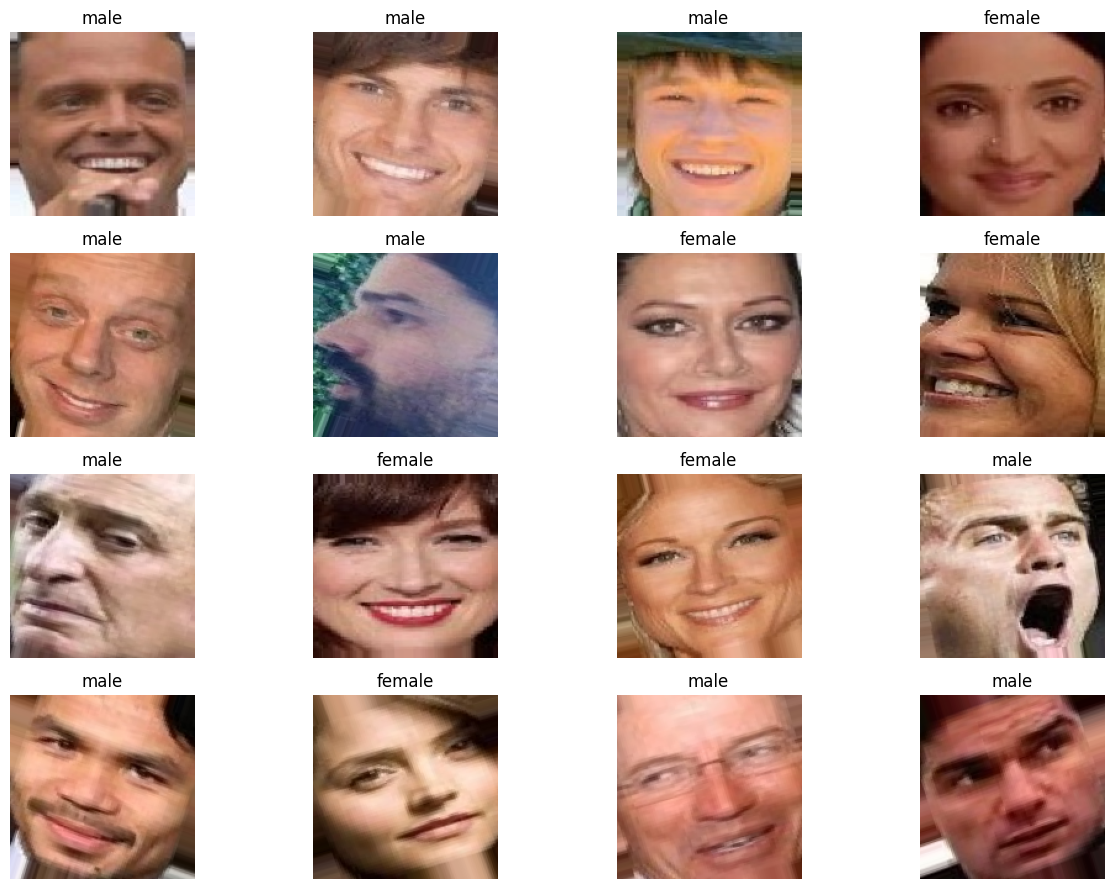

In [9]:
plotImages(x,y) # Hiển thị một số hình ảnh từ tập huấn luyện

5. Khởi tạo mô hình Sequential: Tạo một mô hình mạng nơ-ron tuần tự và thêm các layer Convolutional, MaxPooling, Flatten và Dense vào mô hình.

In [10]:
kernel_s=(3,3) # kích thước kernel

2. Huấn luyện dữ liệu và trích chọn các đặc trưng

khơi tạo mô hình tuân tự

In [11]:
# Khởi tạo mô hình Sequential
model = Sequential()

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3), padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Hiển thị tóm tắt của mô hình
model.summary()

c:\Users\Yoo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 46208)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    11,829,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,923,009 (45.48 MB)

 Trainable params: 11,923,009 (45.48 MB)

 Non-trainable params: 0 (0.00 B)

6. Biên dịch mô hình: Cài đặt hàm mất mát, trình tối ưu và các metric

Sử dụng compile để biên soạn mô hình với trình tối ưu hóa Adam, hàm mất mát là entropy chéo nhị phân (binary_crossentropy), và độ chính xác là độ đo đánh giá hiệu suất của mô hình.

In [12]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])

7. Sử dụng callbacks để theo dõi quá trình huấn luyện, bao gồm dừng sớm nếu độ chính xác trên tập xác thực không cải thiện và lưu trữ mô hình có hiệu suất tốt nhất.

In [13]:
my_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=3,mode="max"),
    ModelCheckpoint("best_model.keras", verbose=1, save_best_only=True) #  tên mô hình best_model.keras được lưu lại
]

8. Huấn luyện mô hình: Sử dụng phương thức fit để huấn luyện mô hình với dữ liệu huấn luyện và xác thực.

In [14]:
history = model.fit(train_gen, steps_per_epoch=10, epochs=10, 
                    validation_data=valid_gen, validation_steps=10, callbacks=my_callbacks)

Epoch 1/10


c:\Users\Yoo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5570 - loss: 1.2087
Epoch 1: val_loss improved from inf to 0.78505, saving model to best_model.keras


c:\Users\Yoo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss
  current = self.get_monitor_value(logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - acc: 0.5586 - loss: 1.1878 - val_acc: 0.4437 - val_loss: 0.7850
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.5192 - loss: 0.7269
Epoch 2: val_loss improved from 0.78505 to 0.67574, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 5s/step - acc: 0.5239 - loss: 0.7242 - val_acc: 0.7188 - val_loss: 0.6757
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.6510 - loss: 0.6663
Epoch 3: val_loss improved from 0.67574 to 0.63012, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - acc: 0.6477 - loss: 0.6677 - val_acc: 0.7000 - val_loss: 0.6301
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.6699 - loss: 0.6395
Epoch 4: val_loss improved from 0.63012 to 0.58864, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step - acc: 0.6689 - loss: 0.6397 - val_acc: 0.7229 - val_loss: 0.5886
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - acc: 0.6984 - loss: 0.6018
Epoch 5: val_

9. Đánh giá mô hình: Đánh giá mô hình trên dữ liệu xác thực để tính toán loss và accuracy.

In [15]:
loss, accuracy = model.evaluate(valid_gen)
print("Loss:", loss)
print("Accuracy:", accuracy)

243/243 ━━━━━━━━━━━━━━━━━━━━ 221s 910ms/step - acc: 0.7828 - loss: 0.4750
Loss: 0.46746185421943665
Accuracy: 0.7883938550949097


10. Dự đoán giới tính từ hình ảnh: Sử dụng mô hình đã đào tạo để dự đoán giới tính từ một hình ảnh mới.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
D:/HocSau_DeeL/Project_Giuaky/Validation/female/113105.jpg.jpg is female


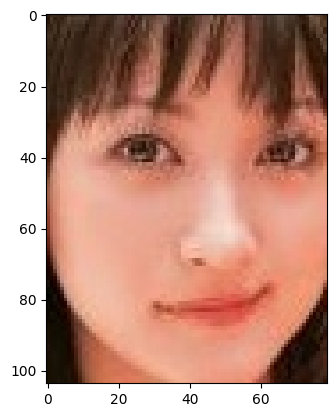

In [4]:
# Load mô hình từ tệp đã huấn luyện
model = load_model("D:/HocSau_DeeL/Project_Giuaky/best_model.keras")
# Hàm dự đoán giới tính của hình ảnh từ đường dẫn
def predict_gender(image_path):
    # Load hình ảnh từ đường dẫn
    img = image.load_img(image_path, target_size=(150,150))
    # Chuyển đổi hình ảnh thành mảng numpy
    x = image.img_to_array(img)
    # Mở rộng chiều dữ liệu (thêm một chiều cho batch)
    x = np.expand_dims(x, axis=0)
    # Dự đoán giới tính
    classes = model.predict(x, batch_size=1)
    # Chuyển đổi dự đoán thành nhãn 'nam' hoặc 'nữ' dựa trên ngưỡng 0.5
    return "male" if classes[0] > 0.5 else "female"
# Đường dẫn của hình ảnh bạn muốn dự đoán
image_path="D:/HocSau_DeeL/Project_Giuaky/Validation/female/113105.jpg.jpg"
#image_path="D:/HocSau_DeeL/Project_Giuaky/Validation/male/063430.jpg.jpg"
# Dự đoán giới tính và hiển thị hình ảnh
gender = predict_gender(image_path)
print(f"{image_path} is {gender}")
img = plt.imread(image_path)
plt.imshow(img)
plt.show()